## Import Libraries 📁

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

## Load the Data 🗂️

In [2]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [ ]:
movies.head(5)

In [ ]:
ratings.head(5)

## Data Preprocessing 🧹

In [3]:
## merage two dataframes
data = movies.merge(ratings, on='movieId')
data.head(5)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [4]:
# Extract year
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
data['year'] = data['timestamp'].dt.year

In [5]:
# check for null cvalues
data.isnull().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
year         0
dtype: int64

In [6]:
# Handle duplicate records
data.drop_duplicates()

,movieId,title,genres,userId,rating,timestamp,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,2000-07-30 18:45:03,2000
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,1996-11-08 06:36:02,1996
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,2005-01-25 06:52:26,2005
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,2017-11-13 12:59:30,2017
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,2011-05-18 05:28:03,2011
...,...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,2018-09-16 14:44:42,2018
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,2018-09-16 14:52:25,2018
100833,193585,Flint (2017),Drama,184,3.5,2018-09-16 14:56:45,2018
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,2018-09-16 15:00:21,2018


## Exploratory Data Analysis 🔎📊🤔

In [7]:
# Basic information
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   movieId    100836 non-null  int64         
 1   title      100836 non-null  object        
 2   genres     100836 non-null  object        
 3   userId     100836 non-null  int64         
 4   rating     100836 non-null  float64       
 5   timestamp  100836 non-null  datetime64[ns]
 6   year       100836 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(2)
memory usage: 5.0+ MB


,movieId,userId,rating,timestamp,year
count,100836.000000,100836.000000,100836.000000,100836,100836.000000
mean,19435.295718,326.127564,3.501557,2008-03-19 17:01:27.368469504,2007.722936
min,1.000000,1.000000,0.500000,1996-03-29 18:36:55,1996.000000
25%,1199.000000,177.000000,3.000000,2002-04-18 09:57:46,2002.000000
50%,2991.000000,325.000000,3.500000,2007-08-02 20:31:02,2007.000000
75%,8122.000000,477.000000,4.000000,2015-07-04 07:15:44.500000,2015.000000
max,193609.000000,610.000000,5.000000,2018-09-24 14:27:30,2018.000000
std,35530.987199,182.618491,1.042529,NaN,6.890376


In [8]:
# Average ratig per movie
Avg_ratig_per_movie = data.groupby('title')['rating'].mean().reset_index()
Avg_ratig_per_movie.sort_values(by='rating', ascending=False)

,title,rating
3354,Gena the Crocodile (1969),5.0
8951,True Stories (1986),5.0
1986,Cosmic Scrat-tastrophe (2015),5.0
5269,Love and Pigeons (1985),5.0
7033,Red Sorghum (Hong gao liang) (1987),5.0
...,...,...
2482,Don't Look Now (1973),0.5
4617,Journey 2: The Mysterious Island (2012),0.5
4581,Joe Dirt 2: Beautiful Loser (2015),0.5
4556,Jesus Christ Vampire Hunter (2001),0.5


In [9]:
# Most Rated movies
most_rated_movies = data.groupby('title')['rating'].count().reset_index().rename(columns={'rating':'Number of Ratings'})
most_rated_movies = most_rated_movies.sort_values(by='Number of Ratings', ascending=False).head(20)
most_rated_movies = most_rated_movies.merge(Avg_ratig_per_movie, on='title').rename(columns={'rating':'Average Rating'})
most_rated_movies

,title,Number of Ratings,Average Rating
0,Forrest Gump (1994),329,4.164134
1,"Shawshank Redemption, The (1994)",317,4.429022
2,Pulp Fiction (1994),307,4.197068
3,"Silence of the Lambs, The (1991)",279,4.161290
4,"Matrix, The (1999)",278,4.192446
5,Star Wars: Episode IV - A New Hope (1977),251,4.231076
6,Jurassic Park (1993),238,3.750000
7,Braveheart (1995),237,4.031646
8,Terminator 2: Judgment Day (1991),224,3.970982
9,Schindler's List (1993),220,4.225000


Text(0.5, 1.0, 'Districution of Ratings')

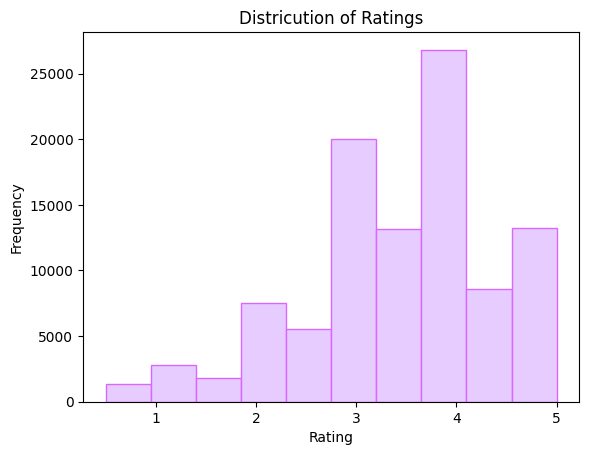

In [10]:
# Histogram - Districution of Ratings
plt.hist(data['rating'], color='#e6ccff', edgecolor='#d966ff')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Districution of Ratings')

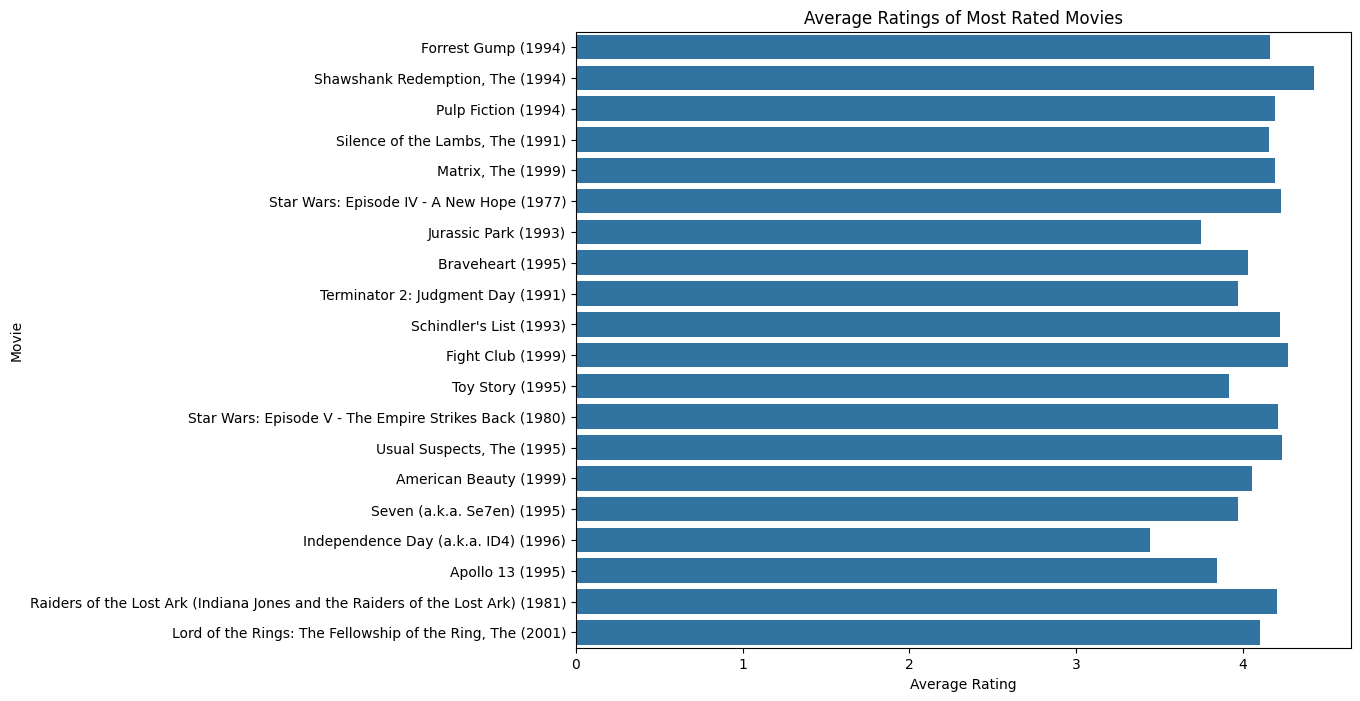

In [11]:
# Average Ratings of Most Rated Movies
plt.figure(figsize=(10,8))
sns.barplot(x=most_rated_movies['Average Rating'], y=most_rated_movies['title'])
plt.xlabel('Average Rating')
plt.ylabel('Movie')
plt.title('Average Ratings of Most Rated Movies')
plt.show()

In [12]:
# Most rated users
data.groupby('userId')['rating'].count().reset_index().sort_values(by='rating', ascending=False).head(20)

,userId,rating
413,414,2698
598,599,2478
473,474,2108
447,448,1864
273,274,1346
609,610,1302
67,68,1260
379,380,1218
605,606,1115
287,288,1055


In [13]:
# Correlation analysis
le = LabelEncoder()
data['genres'] = le.fit_transform(data['genres'])
numeric_columns = data.select_dtypes(include=['number']).columns
numeric_data = data[numeric_columns]
numeric_data.corr()

,movieId,genres,userId,rating,year
movieId,1.000000,-0.077917,0.006773,-0.004061,0.502583
genres,-0.077917,1.000000,0.014733,0.040052,-0.064297
userId,0.006773,0.014733,1.000000,-0.049348,0.100729
rating,-0.004061,0.040052,-0.049348,1.000000,-0.007314
year,0.502583,-0.064297,0.100729,-0.007314,1.000000


In [ ]:
data.head()

In [14]:
# Average ratig per year
Avg_ratig_per_year = data.groupby('year')['rating'].mean().reset_index().rename(columns={'rating':'average rating per year'})
Avg_ratig_per_year.head()

,year,average rating per year
0,1996,3.535927
1,1997,3.727557
2,1998,3.435897
3,1999,3.772448
4,2000,3.392506


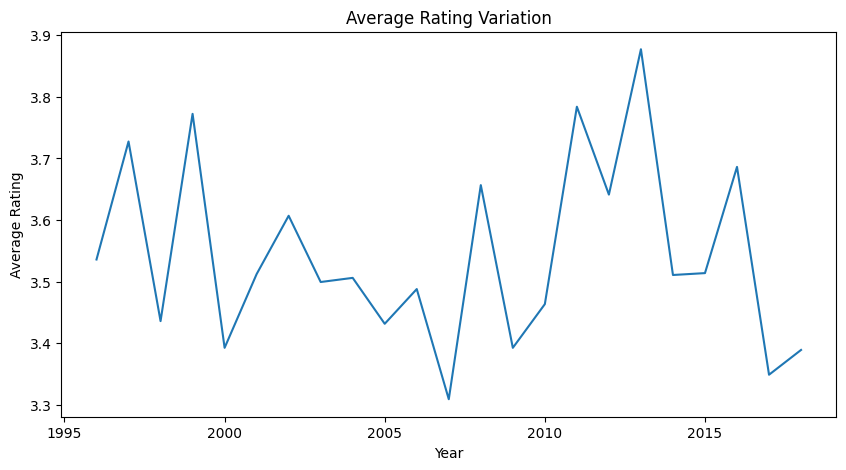

In [15]:
plt.figure(figsize=(10,5))
sns.lineplot(x=Avg_ratig_per_year['year'], y=Avg_ratig_per_year['average rating per year'])
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Rating Variation')
plt.show()

## Trainig the Model 🤖

#### User based Colloborative Filtering

In [39]:
reader = Reader(rating_scale=(data['rating'].min(), data['rating'].max()))
dataset = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)

In [40]:
#Train-Test Split
trainset, testset = train_test_split(dataset, test_size=0.25)

In [41]:
# Define algorithm
algo = SVD()

In [42]:
#Train the Model
algo.fit(trainset)

In [43]:
#Make Predictions
predictions = algo.test(testset)

## Evaluate the Model 😃👍

In [44]:
mse = accuracy.mse(predictions)
rmse = accuracy.rmse(predictions)

MSE: 0.7765
RMSE: 0.8812


An MSE of 0.7765 and an RMSE of 0.8812 indicate that the model's predictions are reasonably close to the actual ratings, with an average prediction error of about 0.88 rating points. These values suggest the model is performing well, but there is still room for improvement.

## Make Predictions 🔮

In [92]:
# function to return top N recommendations
def recommend_movies(algo,userId,data,N):

    all_movies = set(data['movieId'].unique())
    rated_movies = set(data[data['userId'] == userId]['movieId'])
    unrated_movies = all_movies - rated_movies

    predicted_movies  = []
    for movie in unrated_movies:
        prediction =  algo.predict(userId,movie)
        predicted_movies.append(prediction)

    predicted_movies.sort(key= lambda x: x.est, reverse=True)
    top_n = predicted_movies[:N]

    return top_n

In [105]:
# create a dictionary of movie names
movie_names = pd.Series(data.title.values, index=data.movieId).to_dict()

# display recommended movie names
recommendations = recommend_movies(algo,196,data,10)
for prediction in recommendations:
    movie_name = movie_names[prediction.iid]
    print(f"Movie: {movie_name}, Predicted rating: {prediction.est}")

Movie: Streetcar Named Desire, A (1951), Predicted rating: 4.542310034929538
Movie: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964), Predicted rating: 4.514200388364212
Movie: Wallace & Gromit: The Best of Aardman Animation (1996), Predicted rating: 4.405325557451422
Movie: Casablanca (1942), Predicted rating: 4.358079655039991
Movie: It's a Wonderful Life (1946), Predicted rating: 4.3400497505881885
Movie: North by Northwest (1959), Predicted rating: 4.331322096979678
Movie: Philadelphia Story, The (1940), Predicted rating: 4.3245929415384845
Movie: Reservoir Dogs (1992), Predicted rating: 4.320400081185281
Movie: Citizen Kane (1941), Predicted rating: 4.314478548465238
Movie: Fargo (1996), Predicted rating: 4.309951942633791
